# Team Challenge 17 - Pipelines - Team Liberty

<center>
    <img src="foto_notebook.png" alt="PipeLine">

</center>

Importación de librerías:

In [1]:
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb

from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder

warnings.filterwarnings('ignore')

/Users/beatrizcartiel/Desktop/master_DS/TEAM_CHALLENGE_17/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 📌 Índice

#### 1. Problema de negocio y tema  

#### 2. Estructura del análisis  
* ##### 2.1 Análisis numérico  
* ##### 2.2 Tratamiento de los Outliers  
* ##### 2.3 Análisis categórico  

#### 3. Separación y codificación  
* ##### 3.1 Transformaciones  
* ##### 3.2 Pipeline y guardado  

#### 4. Modelos y métricas de evaluación 
* ##### 4.1 🔍 Supervisado - Random Forest  
* ##### 4.2 📊 No supervisado - PCA  

#### 5. 🏁 Conclusiones  


## 1. Problema de negocio y tema

En este estudio, nuestro objetivo es predecir el **salario** de profesionales en ciencia de datos en función de diversas variables relacionadas con el trabajo, la experiencia y la ubicación.

Hemos elegido el conjunto de datos *"Salarios de ciencia de datos 2023"* porque:
Contiene información relevante como: título del trabajo, nivel de experiencia, tipo de empleo, ubicación de la empresa y salario.

Incluye variables numéricas y categóricas, lo que permite aplicar técnicas de preprocesamiento como PCA (no supervisado) y modelos de regresión (supervisado).

El salario es una variable continua, lo que nos lleva a un problema de regresión en lugar de clasificación.
Es útil en la vida real: entender qué factores influyen en el salario puede ayudar tanto a compañeros como a profesionales de datos.
 

DATASET: https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023

In [2]:
df=pd.read_csv("../data/ds_salaries.csv")
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


## 2. Estructura del análisis  

### EXPLORACIÓN Y ANÁLISIS DE LOS DATOS

Vamos a analizar las variables rápidamente:

* **work_year**: Año en que se registró el salario (**numérica**, pero más bien categórica).

* **experience_level**: Nivel de experiencia del trabajador (categórica).
* **employment_type**: Tipo de empleo (categórica: full-time, part-time, etc.).
* **job_title**: Título del trabajo (categórica).
* **salary**: Salario en la moneda local de la empresa (**numérica**).
* **salary_currency**: Moneda del salario original (categórica).
* **salary_in_usd**: Salario convertido a USD (nuestro target, **numérica**).
* **employee_residence**: País de residencia del empleado (categórica).
* **remote_ratio**: Porcentaje de trabajo remoto (**numérica**: 0, 50, 100).
* **company_location**: País donde está la empresa (categórica).
* **company_size**: Tamaño de la empresa (categórica: S, M, L).

#### 2.1 Análisis numérico

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [4]:
# Modficamos la variable Salario que viene como object
print(df["salary"].dtype)  # Si es object, hay que convertirla
df["salary"] = pd.to_numeric(df["salary"], errors="coerce")  # Convierte a número

int64


In [5]:
# Hacemos un describe para ver la pinta de las variables numéricas
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [6]:
# Elegimos la variable target para nuestro modelo
target="salary_in_usd"

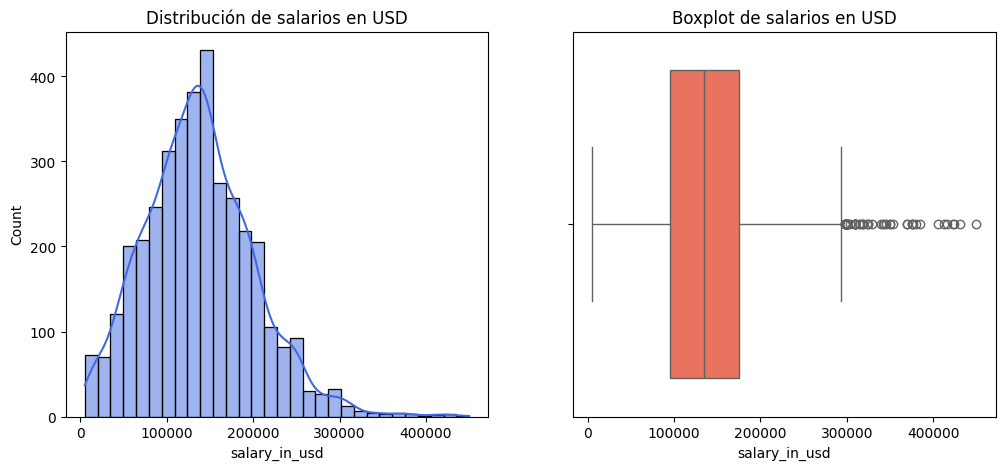

In [7]:
# Visualizamos la varible target mediante un histplot y un boxplot para ver sus outliers

# Ajustar el tamaño de las gráficas y los colores
palette = sns.color_palette("cubehelix", n_colors=10)
plt.figure(figsize=(12, 5))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df["salary_in_usd"], bins=30, kde=True, color="royalblue")
plt.title("Distribución de salarios en USD")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df["salary_in_usd"], color="tomato")
plt.title("Boxplot de salarios en USD")

plt.show()

In [8]:
# Recordamos las columnas del DataFrame
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [9]:
# Seleccionamos solo las variables numéricas
numerical_cols = ["salary", "salary_in_usd", "remote_ratio",'work_year']  # Excluimos work_year por ser más categórica

# Calculamos la correlación en valor absoluto con el target
correlation_values = df[numerical_cols].corr()["salary_in_usd"].abs().sort_values(ascending=False)

# Mostramos los resultados
print(correlation_values)

salary_in_usd    1.000000
work_year        0.228290
remote_ratio     0.064171
salary           0.023676
Name: salary_in_usd, dtype: float64


#### ⚠️ Aquí se detecta algo raro ⚠️
➡️ No tiene sentido que la variable salario no tenga relación con el target, esto puede ser por que ya este bien hecho el cambio de moneda en salary_usd.

Así que lo comprobamos:

In [10]:
print(df["salary_currency"].value_counts())  # Frecuencia de cada moneda
print(df["salary_currency"].unique())  # Lista de monedas únicas

salary_currency
USD    3224
EUR     236
GBP     161
INR      60
CAD      25
AUD       9
SGD       6
BRL       6
PLN       5
CHF       4
HUF       3
DKK       3
JPY       3
TRY       3
THB       2
ILS       1
HKD       1
CZK       1
MXN       1
CLP       1
Name: count, dtype: int64
['EUR' 'USD' 'INR' 'HKD' 'CHF' 'GBP' 'AUD' 'SGD' 'CAD' 'ILS' 'BRL' 'THB'
 'PLN' 'HUF' 'CZK' 'DKK' 'JPY' 'MXN' 'TRY' 'CLP']


In [11]:
# Ver algunas filas con diferentes monedas para comprobar la conversión
sample_rows = df[df["salary_currency"].isin(["EUR", "INR", "GBP", "HKD", "AUD"])]  # Seleccionamos varias monedas
sample_rows[["salary", "salary_currency", "salary_in_usd"]].head(10)

,salary,salary_currency,salary_in_usd
0,80000,EUR,85847
41,1650000,INR,20984
80,510000,HKD,65062
82,65000,EUR,69751
84,90000,EUR,96578
91,45000,EUR,48289
92,36000,EUR,38631
156,1700000,INR,20670
157,38000,GBP,46178
158,35000,GBP,42533


Comprobamos que las conversiones están bien hechas, por lo que nos sobrarían las variables 'salary', 'salary_currency'. 

Por lo tanto, nos quedariamos simplemente con **'work_year'** como variable numérica, luego veremos qué hacemos con el año, por que tampoco tiene mucha correlación.

#### 2.2 Tatamiento de outliers

Mostramos un boxplot para comprobar los outliers y luego decidiremos cómo los tratamos.

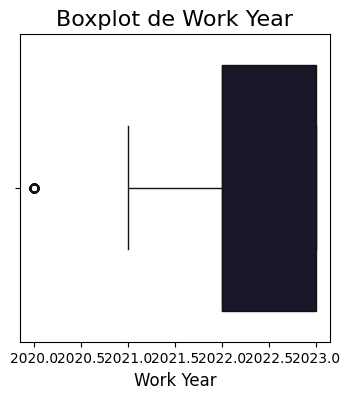

In [12]:
# Primero de Work Year

# Definir la paleta de colores
palette = sns.color_palette("cubehelix", n_colors=10)# Crear un boxplot para 'work_year'

plt.figure(figsize=(4, 4))
sns.boxplot(x=df['work_year'], palette=palette)

# Títulos y etiquetas
plt.title('Boxplot de Work Year', fontsize=16)
plt.xlabel('Work Year', fontsize=12)

# Mostrar gráfico
plt.show()

En este caso como considera outlier el año 2020 pero no hay fundamento en eso, lo ajustamos para que no lo considere outlier

In [13]:
# Calcular el IQR
Q1 = df['work_year'].quantile(0.25)
Q3 = df['work_year'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites ajustados
lower_limit = Q1 - 2.5 * IQR  # Aumenta o disminuye el 2.5 para ajustarlo
upper_limit = Q3 + 2.5 * IQR  # Aumenta o disminuye el 2.5 para ajustarlo

# Filtrar los outliers con los nuevos límites
outliers_work_year = df[(df['work_year'] < lower_limit) | (df['work_year'] > upper_limit)]
print("Outliers ajustados en work_year:", outliers_work_year)

Outliers ajustados en work_year: Empty DataFrame
Columns: [work_year, experience_level, employment_type, job_title, salary, salary_currency, salary_in_usd, employee_residence, remote_ratio, company_location, company_size]
Index: []


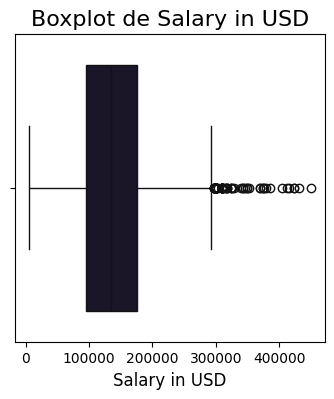

In [14]:
# Miramos los outliers de la variable target

# Definir la paleta de colores
palette = sns.color_palette("cubehelix", n_colors=10)

# Crear un boxplot para 'salary_in_usd'
plt.figure(figsize=(4, 4))
sns.boxplot(x=df['salary_in_usd'], palette=palette)

# Títulos y etiquetas
plt.title('Boxplot de Salary in USD', fontsize=16)
plt.xlabel('Salary in USD', fontsize=12)

# Mostrar gráfico
plt.show()

In [15]:
# Primero, definimos una función para calcular los outliers de nuestra variable target usando el IQR
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar los outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Detectar outliers en 'Salary_in_USD'
outliers_salary_usd = detect_outliers(df, 'salary_in_usd')
print("Outliers en 'Salary_in_USD':")
print(outliers_salary_usd[['salary_in_usd']])


Outliers en 'Salary_in_USD':
      salary_in_usd
33           342810
68           309400
83           300000
133          342300
145          318300
...             ...
3522         450000
3675         416000
3697         325000
3747         423000
3750         412000

[63 rows x 1 columns]


In [16]:
# Índices de los outliers de Salary in USD que mencionas
outlier_indices = [33, 68, 83, 133, 145, 3522, 3675, 3697, 3747, 3750]

# Filtrar los registros correspondientes a estos outliers y mostrar las columnas relevantes
outlier_data = df.iloc[outlier_indices][['job_title', 'salary_in_usd', 'work_year', 'employee_residence']]
outlier_data

,job_title,salary_in_usd,work_year,employee_residence
33,Computer Vision Engineer,342810,2023,US
68,Applied Scientist,309400,2023,US
83,AI Developer,300000,2022,IN
133,Machine Learning Engineer,342300,2023,US
145,Machine Learning Engineer,318300,2023,US
3522,Research Scientist,450000,2020,US
3675,Principal Data Scientist,416000,2021,US
3697,Director of Data Science,325000,2020,US
3747,Applied Machine Learning Scientist,423000,2021,US
3750,Data Scientist,412000,2020,US


En este caso, parece que los outliers son legítimos y representan roles profesionales de alto nivel.

Por tanto **no** los eliminamos, pero les aplicaremos una transformación logarítmica o un escalado para asegurarnos de que no distorsionen la PCA o el rendimiento de los modelos de Machine Learning. 

Esto nos permitirá trabajar con estos outliers sin perder validez en el análisis y predicción.

#### 2.3 Análisis categórico

In [17]:
# Agrupamos todas las variables categóricas
categorical_cols = ['experience_level', 'employment_type', 'job_title', 
                    'salary_currency', 'employee_residence', 'company_location', 'company_size']

# Calculamos la cardinalidad en porcentaje de las variables categóricas:
for col in categorical_cols:
    print(f"\nCardinalidad para {col}:")
    cardinality = df[col].nunique()  # Calcula la cardinalidad de la variable
    total = len(df[col])  # Total de elementos de la columna
    cardinality_percentage = (cardinality / total) * 100  # Porcentaje de cardinalidad respecto al total
    print(f"Cardinalidad: {cardinality} valores únicos")
    print(f"Porcentaje de la cardinalidad: {cardinality_percentage:.2f}%")


Cardinalidad para experience_level:
Cardinalidad: 4 valores únicos
Porcentaje de la cardinalidad: 0.11%

Cardinalidad para employment_type:
Cardinalidad: 4 valores únicos
Porcentaje de la cardinalidad: 0.11%

Cardinalidad para job_title:
Cardinalidad: 93 valores únicos
Porcentaje de la cardinalidad: 2.48%

Cardinalidad para salary_currency:
Cardinalidad: 20 valores únicos
Porcentaje de la cardinalidad: 0.53%

Cardinalidad para employee_residence:
Cardinalidad: 78 valores únicos
Porcentaje de la cardinalidad: 2.08%

Cardinalidad para company_location:
Cardinalidad: 72 valores únicos
Porcentaje de la cardinalidad: 1.92%

Cardinalidad para company_size:
Cardinalidad: 3 valores únicos
Porcentaje de la cardinalidad: 0.08%


__Descripción exahustiva de las variables categóricas:__

➡️ **Experience Level (4 categorías):** *Junior, Mid, Senior, Executive*. Clasificación de nivel de experiencia de los empleados.

➡️ **Employment Type (4 categorías):** *Full-time, Part-time, Contract, y otra modalidad*. Diferentes tipos de contrato laboral.

➡️ **Job Title (93 categorías):** Gran diversidad de roles dentro de la ciencia de datos.

➡️ **Salary Currency (20 categorías):** Variedad de monedas reflejando la globalización del mercado laboral.

➡️ **Employee Residence (78 categorías):** Diversidad geográfica, empleados ubicados en múltiples países.

➡️ **Company Location (72 categorías):** Empresas ubicadas en varios países, indicando una distribución global.

➡️ **Company Size (3 categorías):** Pequeñas, medianas y grandes empresas, con implicaciones en salario y beneficios.

In [18]:
# Definir las variables categóricas
categorical_vars = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size','salary_currency']

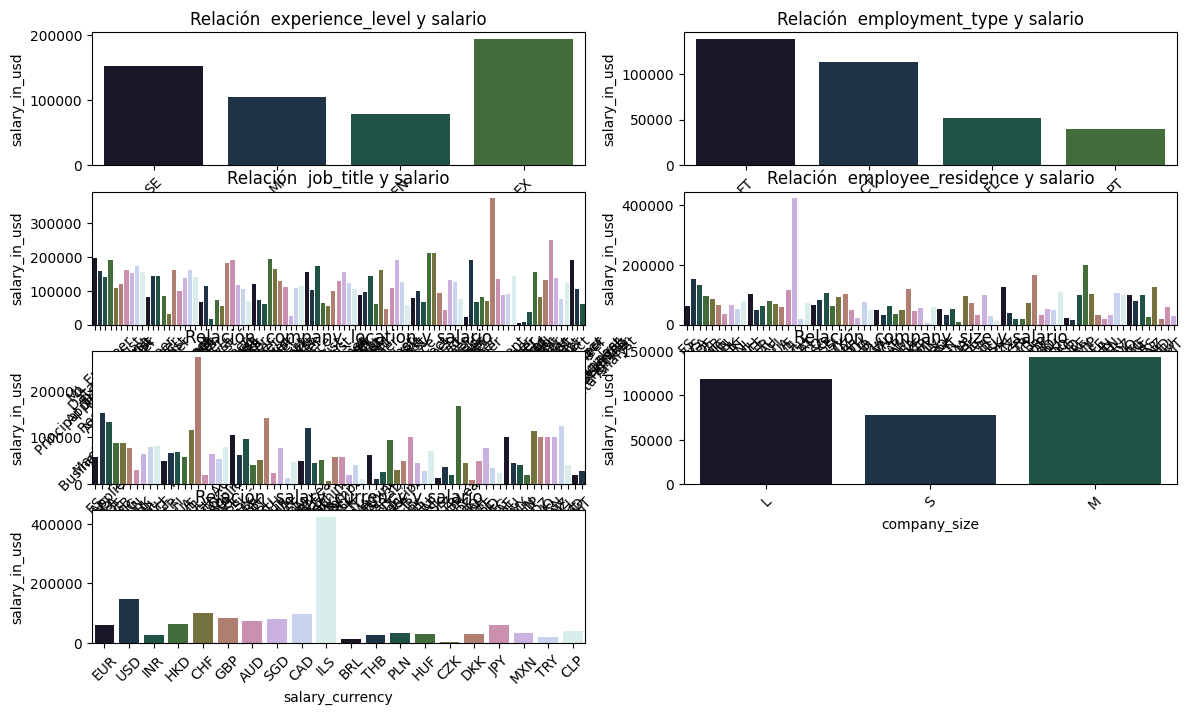

In [19]:
# Visualización de las variables categóricas

palette = sns.color_palette("cubehelix", n_colors=10)
plt.figure(figsize=(14, 10))

# Graficar la relación entre las variables categóricas y el salario en USD (usando el promedio)
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(5, 2, i)  # Crear una cuadrícula 2x3 para los gráficos
    sns.barplot(x=var, y='salary_in_usd', data=df, estimator='mean', ci=None, palette=palette)
    plt.xticks(rotation=45)
    plt.title(f'Relación  {var} y salario')

plt.tight_layout()
plt.show()

Para cada variable categórica que tiene muchos valores únicos (como *employee_residence*, *company_location*, y *job_title*), vamos a filtrar y mostrar solo los 10 valores más frecuentes (más repetidos).

Luego, representamos estos 10 valores en un gráfico de barras para ver cómo se distribuye el salario (*salary_in_usd*) en cada uno de esos valores más frecuentes.

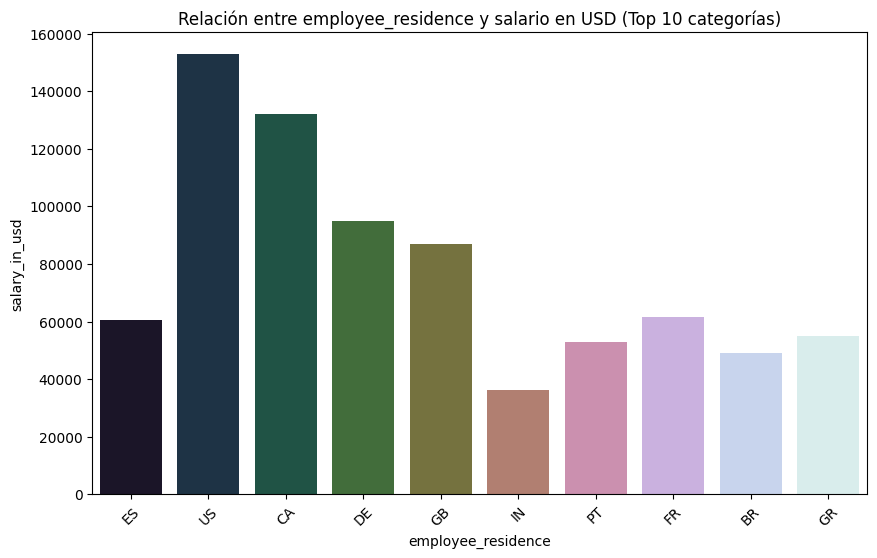

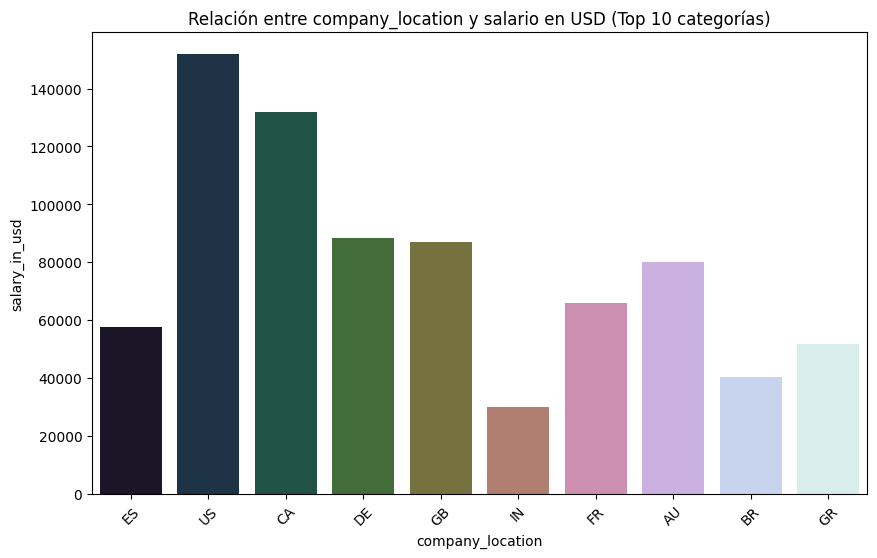

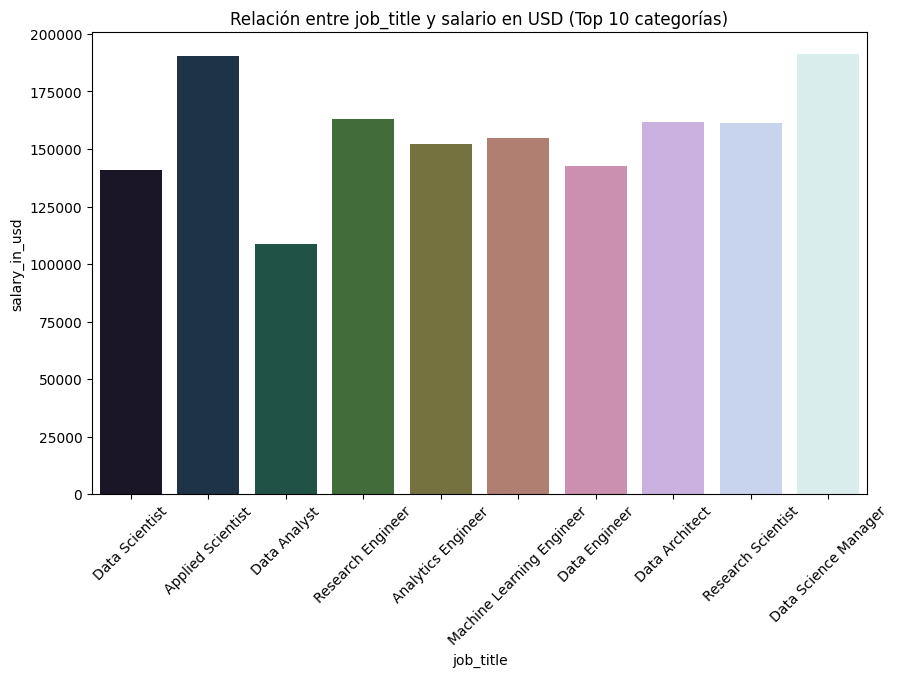

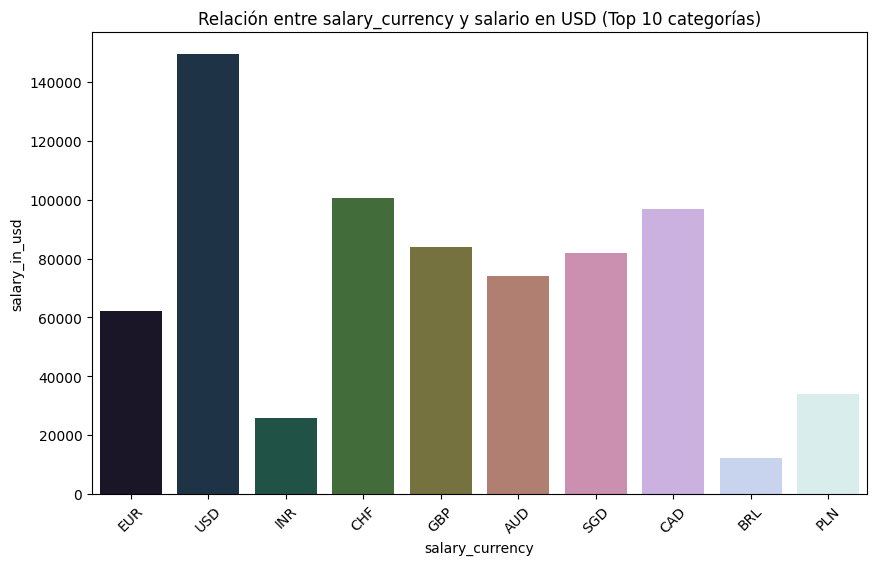

In [20]:
# Función para graficar las 10 categorías más frecuentes en una variable categórica
def plot_top_10_categories(df, column_name):
    # Obtener las 10 categorías más frecuentes
    top_10 = df[column_name].value_counts().nlargest(10).index
    
    # Filtrar el dataset para que solo contenga esos 10 valores más frecuentes
    df_filtered = df[df[column_name].isin(top_10)]
    
    # Graficar el salario medio de cada una de las 10 categorías más frecuentes
    palette = sns.color_palette("cubehelix", n_colors=10)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=column_name, y='salary_in_usd', data=df_filtered, estimator='mean', ci=None, palette=palette)
    plt.xticks(rotation=45)
    plt.title(f'Relación entre {column_name} y salario en USD (Top 10 categorías)')
    plt.show()

# Graficar las 10 categorías más frecuentes de cada variable
categorical_vars = ['employee_residence', 'company_location', 'job_title','salary_currency']

for var in categorical_vars:
    plot_top_10_categories(df, var)

1. *Relación entre Experience Level y Salario*:  
   Los roles con más experiencia, como *X (Executive o Expert)*, tienen una mayor correlación con salarios más altos. Es decir, a mayor experiencia, mayor salario.

2. *Relación entre Employment Type y Salario*:  
   Las posiciones *Full-Time (FT)* tienen salarios más altos que las de *Contract (CT)*. Cuanto más tiempo trabajes, más alto es el salario.

3. *Relación entre Company Size y Salario*:  
   Las *empresas medianas* ofrecen salarios más competitivos que las grandes empresas.

4. *Relación entre Employee Residence y Salario*:  
   Los empleados ganan más en *EE. UU.*, seguidos de *Canadá*, *Alemania* y *Reino Unido*, mientras que *Francia* y *España* están a la cola, aunque se están poniendo al día.

5. *Relación entre Company Location y Salario*:  
   Las empresas ubicadas en *EE. UU.* y *Canadá* ofrecen los salarios más altos, seguido por *Alemania*, *Reino Unido* y *Australia*.

6. *Relación entre Job Title y Salario*:  
   Las personas que más cobran son las que tienen los siguientes cargos:
   - *Data Science Manager*: Lidera equipos y gestiona proyectos de ciencia de datos.
   - *Applied Scientist*: Aplica ciencias para resolver problemas prácticos con IA.
   - *Research Engineer*: Desarrolla e implementa soluciones innovadoras.
   - *Data Architect*: Diseña la estructura de las bases de datos.
   - *Research Scientist*: Realiza investigaciones científicas profundas.

In [21]:
# Realizamos el ANOVA para cada variable categórica en relación con la variable 'salary_in_usd'
for col in categorical_cols:
    # Realizamos ANOVA para cada categoría comparada con 'salary_in_usd'
    print(f"\nANOVA para la variable: {col}")
    groups = [df[df[col] == category]['salary_in_usd'] for category in df[col].unique()]
    
    # Realizamos el test de ANOVA
    f_stat, p_value = stats.f_oneway(*groups)
    
    print(f"Estadístico F: {f_stat}")
    print(f"Valor p: {p_value}")
    
    # Interpretación del valor p
    if p_value < 0.05:
        print(f"Resultado: Existe una diferencia significativa entre los grupos de {col}.")
    else:
        print(f"Resultado: No hay diferencia significativa entre los grupos de {col}.")


ANOVA para la variable: experience_level
Estadístico F: 310.84425170411885
Valor p: 3.0989451417587622e-180
Resultado: Existe una diferencia significativa entre los grupos de experience_level.

ANOVA para la variable: employment_type
Estadístico F: 20.850249944174553
Valor p: 2.1508841037278986e-13
Resultado: Existe una diferencia significativa entre los grupos de employment_type.

ANOVA para la variable: job_title
Estadístico F: 6.994979915062784
Valor p: 1.4805358300187946e-75
Resultado: Existe una diferencia significativa entre los grupos de job_title.

ANOVA para la variable: salary_currency
Estadístico F: 60.833914238777346
Valor p: 5.599609240599029e-202
Resultado: Existe una diferencia significativa entre los grupos de salary_currency.

ANOVA para la variable: employee_residence
Estadístico F: 19.52859994361009
Valor p: 6.198150859506961e-216
Resultado: Existe una diferencia significativa entre los grupos de employee_residence.

ANOVA para la variable: company_location
Estadíst

En general, los resultados de ANOVA nos dicen que las variables categóricas que hemos analizado (nivel de experiencia, tipo de empleo, cargo, moneda de salario, y tamaño de la empresa) **están relacionadas de forma significativa con el salario**. 

Esto implica que cada una de estas variables puede influir de manera importante en la variación del salario, y deberían ser consideradas al momento de analizar o predecir los sueldos en un contexto de ciencia de datos.

## 3. Separación y Codificación

In [22]:
df_original=df.copy()

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


#### 3.1 Transformaciones

Vamos a tranformar las variables categoricas para poder usarlas tanto en la PCA como en el modelo supervisado:
* Primero creamos dos mapeos de las categorias que solamente tienen pocos valores çunicos como la experiencia que tiene 4 valores la transformamos en ordinal ya que va por orden de experiencia.
* El tamaño de empresa también la tansformamos en ordinal ya que sus valores únicos son 3: Small, Medium y Large.
* El resto las pasamos por el pipeline.  Sin embargo, 4 de estas variables las agrupamos previamente por salario con una funcion para que estén mejor asignadas:  *company_ location*, *job_title*, *employment type*, *employee residence*.

In [24]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')

In [25]:
# Mapeo de Experience Level
experience_level_map = {
    'SE': 1,  # Junior
    'MI': 2,  # Mid-level
    'EX': 3,  # Senior
    'EN': 4   # Expert
}

# Mapeo de Company Size (Esto también podría ser OneHotEncoding si no hay un orden claro)
company_size_map = {
    'S': 1,   # Small
    'M': 2,   # Medium
    'L': 3    # Large
}

df['experience_level_encoded'] = df['experience_level'].map(experience_level_map)
df['company_size_encoded'] = df['company_size'].map(company_size_map)

In [26]:
df.columns

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size',
       'experience_level_encoded', 'company_size_encoded'],
      dtype='object')

In [27]:
# Eliminamos las columnas categóricas porque ya las hemos convertido en numéricas
df=df.drop(['experience_level','company_size'], axis=1)
df

,work_year,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,experience_level_encoded,company_size_encoded
0,2023,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,1,3
1,2023,CT,ML Engineer,30000,USD,30000,US,100,US,2,1
2,2023,CT,ML Engineer,25500,USD,25500,US,100,US,2,1
3,2023,FT,Data Scientist,175000,USD,175000,CA,100,CA,1,2
4,2023,FT,Data Scientist,120000,USD,120000,CA,100,CA,1,2
...,...,...,...,...,...,...,...,...,...,...,...
3750,2020,FT,Data Scientist,412000,USD,412000,US,100,US,1,3
3751,2021,FT,Principal Data Scientist,151000,USD,151000,US,100,US,2,3
3752,2020,FT,Data Scientist,105000,USD,105000,US,100,US,4,1
3753,2020,CT,Business Data Analyst,100000,USD,100000,US,100,US,4,3


In [28]:
# Agrupamos las variables por salarios
def group_by_salary(df, column):
    # Definir los intervalos de salario
    salary_bins = [0, 60000, 90000, 150000, 200000, float('inf')]
    salary_labels = ['Low', 'Medium', 'High', 'Very High', 'Extremely High']
    
    # Crear la nueva columna con los grupos basados en salario
    df[column + '_grouped'] = pd.cut(df['salary_in_usd'], bins=salary_bins, labels=salary_labels, right=False)
    return df

# Agrupar las variables que tienen alto cardinalidad por salario
df = group_by_salary(df, 'job_title')
df = group_by_salary(df, 'employee_residence')
df = group_by_salary(df, 'company_location')
df = group_by_salary(df, 'salary_currency')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   work_year                   3755 non-null   int64   
 1   employment_type             3755 non-null   object  
 2   job_title                   3755 non-null   object  
 3   salary                      3755 non-null   int64   
 4   salary_currency             3755 non-null   object  
 5   salary_in_usd               3755 non-null   int64   
 6   employee_residence          3755 non-null   object  
 7   remote_ratio                3755 non-null   int64   
 8   company_location            3755 non-null   object  
 9   experience_level_encoded    3755 non-null   int64   
 10  company_size_encoded        3755 non-null   int64   
 11  job_title_grouped           3755 non-null   category
 12  employee_residence_grouped  3755 non-null   category
 13  company_location_g

## 3.2 PIPELINES

In [30]:


# ================================
# 2️⃣ Preprocesamiento del dataset
# ================================

# 🔸 Eliminamos columnas originales que hemos agrupado previamente (supongo que hiciste grouping antes)
df = df.drop(['job_title', 'salary_currency', 'employee_residence', 'company_location'], axis=1)

# 🔸 Definimos columnas categóricas ya agrupadas
categorical_columns = [
    'employment_type', 'experience_level_encoded', 'company_size_encoded',
    'job_title_grouped', 'employee_residence_grouped', 'company_location_grouped',
    'salary_currency_grouped'
]

# 🔸 Pipeline para transformar variables categóricas
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_transformer = Pipeline(steps=[
    ('impute_mode', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder)
])

# 🔸 Función para aplicar logaritmo a las variables numéricas (evita problemas con ceros)
def log_transform(x):
    return np.log1p(x)

# 🔸 Definimos columnas numéricas
numerical_columns = ['salary_in_usd', 'salary', 'remote_ratio', 'work_year']

# 🔸 Pipeline para transformar variables numéricas
numerical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer()),
    ('log', FunctionTransformer(log_transform, validate=False)),
    ('scaler', MinMaxScaler())
])

# ================================
# 3️⃣ División en train/test
# ================================

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# 🔸 Guardamos los conjuntos para futura referencia
train_set.to_csv("../data/salaries_train.csv", index=False)
test_set.to_csv("../data/salaries_test.csv", index=False)

# 🔸 Definimos X e y
X_train = train_set.copy()
y_train = train_set['salary_in_usd']

X_test = test_set.copy()
y_test = test_set['salary_in_usd']

# ================================
# 4️⃣ Definición del preprocesador
# ================================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='drop'  # Eliminamos columnas no incluidas
)

# ================================
# 5️⃣ Definición de modelos y grids
# ================================

models = {
    'Linear_Regression': LinearRegression(),
    'Random_Forest': RandomForestRegressor(random_state=42),
    'Gradient_Boosting': GradientBoostingRegressor(random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42, verbose=-1)
}

# 🔸 Definimos grids de hiperparámetros para GridSearchCV
param_grids = {
    'Linear_Regression': {},  # Sin hiperparámetros relevantes
    'Random_Forest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 10, 20]
    },
    'Gradient_Boosting': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5]
    },
    'LightGBM': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.05, 0.1],
        'model__num_leaves': [31, 50]
    }
}

# ================================
# 6️⃣ Entrenamiento + GridSearchCV
# ================================

cv_results = {}

for name, model in models.items():
    print(f"\n🔍 Realizando Grid Search para {name}...")

    # Construimos pipeline para cada modelo
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Obtenemos el grid específico para el modelo
    param_grid = param_grids.get(name, {})

    # Grid Search
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    # Resultados
    best_score = -grid_search.best_score_
    best_params = grid_search.best_params_

    cv_results[name] = {
        'RMSE': best_score,
        'Params': best_params,
        'Model': grid_search.best_estimator_
    }

    print(f"{name}: Mejor RMSE {best_score:.2f}")
    print(f"Mejores hiperparámetros: {best_params}")

    # Guardar pipeline entrenado
    joblib.dump(grid_search.best_estimator_, f"../models/pipeline_{name}.joblib")
    print(f"💾 Guardado en: ../models/pipeline_{name}.joblib")

# ================================
# 7️⃣ Mostrar resultados finales
# ================================

print("\n📊 Resultados finales:")
for model_name, info in cv_results.items():
    print(f"{model_name}: RMSE {info['RMSE']:.2f} - Hiperparámetros: {info['Params']}")

# Encontrar el mejor modelo
best_model_name = min(cv_results, key=lambda k: cv_results[k]['RMSE'])
best_rmse = cv_results[best_model_name]['RMSE']
best_params = cv_results[best_model_name]['Params']

print(f"\n🏆 ¡El mejor modelo es **{best_model_name}** con un RMSE de {best_rmse:.2f}!")
print(f"📌 Mejores hiperparámetros: {best_params}")


🔍 Realizando Grid Search para Linear_Regression...
Linear_Regression: Mejor RMSE 15649.70
Mejores hiperparámetros: {}
💾 Guardado en: ../models/pipeline_Linear_Regression.joblib

🔍 Realizando Grid Search para Random_Forest...
Random_Forest: Mejor RMSE 1089.40
Mejores hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 100}
💾 Guardado en: ../models/pipeline_Random_Forest.joblib

🔍 Realizando Grid Search para Gradient_Boosting...
Gradient_Boosting: Mejor RMSE 869.89
Mejores hiperparámetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
💾 Guardado en: ../models/pipeline_Gradient_Boosting.joblib

🔍 Realizando Grid Search para LightGBM...


/Users/beatrizcartiel/Desktop/master_DS/TEAM_CHALLENGE_17/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/beatrizcartiel/Desktop/master_DS/TEAM_CHALLENGE_17/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/beatrizcartiel/Desktop/master_DS/TEAM_CHALLENGE_17/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/beatrizcartiel/Desktop/master_DS/TEAM_CHALLENGE_17/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/beatrizcartiel/Desktop/ma

LightGBM: Mejor RMSE 2921.49
Mejores hiperparámetros: {'model__learning_rate': 0.1, 'model__n_estimators': 100, 'model__num_leaves': 31}
💾 Guardado en: ../models/pipeline_LightGBM.joblib

📊 Resultados finales:
Linear_Regression: RMSE 15649.70 - Hiperparámetros: {}
Random_Forest: RMSE 1089.40 - Hiperparámetros: {'model__max_depth': None, 'model__n_estimators': 100}
Gradient_Boosting: RMSE 869.89 - Hiperparámetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
LightGBM: RMSE 2921.49 - Hiperparámetros: {'model__learning_rate': 0.1, 'model__n_estimators': 100, 'model__num_leaves': 31}

🏆 ¡El mejor modelo es **Gradient_Boosting** con un RMSE de 869.89!
📌 Mejores hiperparámetros: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 100}
